In [1]:
import csv
import os
import pandas as pd
import numpy as np
import copy
import time
import pickle

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB, CategoricalNB


from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

import sklearn.model_selection as model_selection
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Activation, GRU
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

2022-09-06 10:34:44.875281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 10:34:44.875308: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# usefull fucntions
def remove_nan_values(sample_array:np.array) -> np.array:
    for sample_index, i in enumerate(sample_array):
        for value_index, j in enumerate(i):
            if j==' ':
               sample_array[sample_index][value_index] = 0.0
            elif type(j) == str:
                sample_array[sample_index][value_index] = int(j)
            elif np.isnan(j):
               sample_array[sample_index][value_index] = 0.0
    return sample_array

def remove_1d_array_nan_values(sample_array: np.array, attack_categories: dict) -> np.array:
    for value_index, j in enumerate(sample_array):
        if j==' ':
           sample_array[value_index] = 0.0
        elif type(j) == str:
            try:
                sample_array[value_index] = int(j)
            except:
                sample_array[value_index] = attack_categories[j]
        elif np.isnan(j):
           sample_array[value_index] = 0.0
    return sample_array

def save_model(model, name, prefix) -> None:
    """Function responsible for saving trained model. It must be called
    after defining, training and predict.

    :param: None
    :return: None
    """

    filename = f"{name}_{prefix}.sav"
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filepath):
    """Function responsible for load model.

    :param: None
    :return: None
    """
    return pickle.load(open(filepath, 'rb'))

In [3]:
columns = ['pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'pkt', 'bytes', 'state', 'ltime',
           'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate',
           'drate', 'attack', 'category', 'subcategory']

In [11]:
df_path = '/home/mkubita/Pulpit/Praca Magisterska/Zbiory danych/BoT_IoT/'
files = [file for file in os.listdir(df_path) if 'UNSW_2018' in file]
li = []
for file in files:
    csv_file = os.path.join(df_path, file)
    df = pd.read_csv(csv_file, index_col=None, header=0)
    li.append(df)
frame = pd.concat(li, ignore_index=True)
frame[]

In [13]:
frame.shape[0]

3668522

In [14]:
df_path = '/home/mkubita/Pulpit/Praca Magisterska/Zbiory danych/BoT_IoT/All_dataset'
files = [file for file in os.listdir(df_path) if 'UNSW_2018_IoT_Botnet_Dataset' in file]
li = []

for file in files:
    csv_file = os.path.join(df_path, file)
    try:
        df = pd.read_csv(csv_file, index_col=None, header=0)
        df = df.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24'])
        df.columns = columns
        li.append(df[df['attack']== 1].sample(len(df[df['attack']== 0])))
        li.append(df[df['attack']== 0])
    except:
        pass

/home/mkubita/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
frame = pd.concat(li, ignore_index=True)
frame

,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkt,bytes,...,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory
0,68522931,1.528101e+09,e,udp,192.168.100.149,54951,192.168.100.6,80,9,540,...,9,0,540,0,0.247937,0.247937,0.000000,1,DDoS,UDP
1,68327005,1.528101e+09,e,udp,192.168.100.150,40750,192.168.100.6,80,9,540,...,9,0,540,0,0.195967,0.195967,0.000000,1,DDoS,UDP
2,68190663,1.528101e+09,e,udp,192.168.100.148,11611,192.168.100.6,80,9,540,...,9,0,540,0,0.192761,0.192761,0.000000,1,DDoS,UDP
3,68441146,1.528101e+09,e,udp,192.168.100.148,26294,192.168.100.6,80,10,600,...,10,0,600,0,0.263833,0.263833,0.000000,1,DDoS,UDP
4,68895564,1.528101e+09,e,udp,192.168.100.148,22248,192.168.100.6,80,7,420,...,7,0,420,0,0.062484,0.062484,0.000000,1,DDoS,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18065,11875821,1.528083e+09,e,tcp,192.168.100.6,80.0,192.168.100.3,80.0,1520,449920,...,1520,0,449920,0,26.982244,26.982244,0.000000,0,Normal,Normal
18066,11875822,1.528083e+09,e,tcp,192.168.100.46,80.0,192.168.100.5,80.0,4501,4211666,...,4501,0,4211666,0,79.934235,79.934235,0.000000,0,Normal,Normal
18067,11876015,1.528083e+09,e,tcp,192.168.100.5,0.0,192.168.100.3,0.0,2700,1920364,...,2700,0,1920364,0,47.963837,47.963837,0.000000,0,Normal,Normal
18068,11876016,1.528083e+09,e,udp,192.168.100.7,365.0,192.168.100.3,565.0,2420,145200,...,2420,0,145200,0,42.977547,42.977547,0.000000,0,Normal,Normal


In [17]:
frame.shape[0]

18070

In [10]:
frame['category']

0          DDoS
1          DDoS
2          DDoS
3          DDoS
4          DDoS
          ...  
18065    Normal
18066    Normal
18067    Normal
18068    Normal
18069    Normal
Name: category, Length: 18070, dtype: object

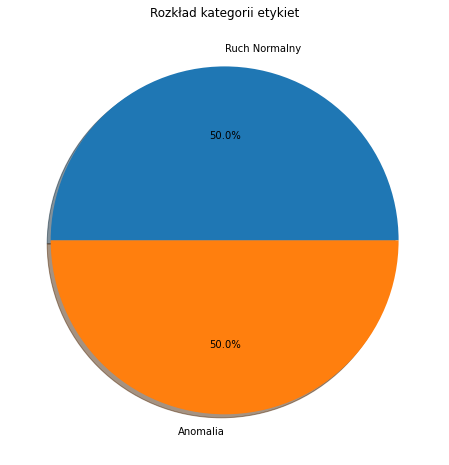

In [8]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii etykiet")
plt.pie([frame[frame['attack'] == 0].shape[0], frame[frame['attack'] == 1].shape[0]],
       labels=['Ruch Normalny', 'Anomalia'], autopct='%1.1f%%', shadow=True)
plt.show()

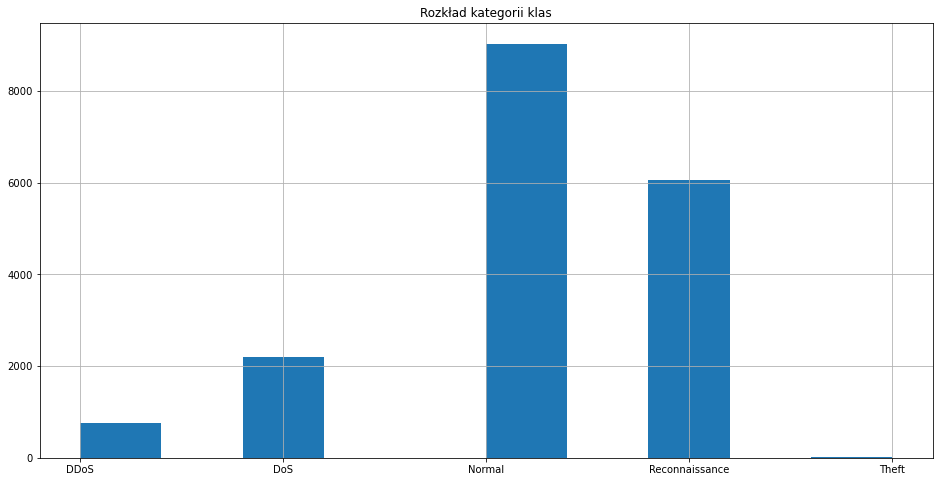

In [12]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii klas")
plt.hist(frame['category'].sort_values())
plt.show()

In [6]:
features_to_remove = ['pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'state', 'category', 'subcategory']
features = list(frame.columns)
for i in features_to_remove:
    if i in features:
        features.remove(i)

In [7]:
features

['pkt',
 'bytes',
 'ltime',
 'seq',
 'dur',
 'mean',
 'stddev',
 'sum',
 'min',
 'max',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'srate',
 'drate',
 'attack']

In [115]:
# # OLD
# features = list(frame.columns)
# for i in ['pkSeqID', 'proto_number', 'saddr', 'sport', 
#           'daddr', 'dport', 'flgs', 'flgs_number', 'category', 'subcategory', 'TnP_Per_Dport', 'TnP_PerProto', 'stime', 'pkts', 'dur', 'mean', 'dpkt', 'sbytes',
#          'max', 'spkts', 'dpkts', 'proto', 'bytes', 'state']:
#     if i in features:
#         features.remove(i)

# # categorical features
# cat_features = ['state', 'proto', 'state_number']
# for i in cat_features:
#     encoder = LabelEncoder()
#     frame[i] = encoder.fit_transform(frame[i])

### Binary classification

In [7]:
# prepare data for classification

df = frame[features].dropna()
features_x = features[:-1]

x = df[features_x].to_numpy()
y = df['attack'].to_numpy()

# normalization min max
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [8]:
# split data
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y,
                                                                    train_size=0.80,
                                                                    test_size=0.20,
                                                                    random_state=101)

In [9]:
models = [GaussianNB(), 
          DecisionTreeClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2),
          RandomForestClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2,
                                 n_estimators=75),
          MLPClassifier(
                        hidden_layer_sizes=(15,30,60),
                        solver="adam",
                        activation="relu",
                        learning_rate_init=0.002,
                        learning_rate="adaptive",
                        max_iter=2000
                       ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',
                                                                   random_state=10,
                                                                   class_weight='balanced',
                                                                   max_depth=11,
                                                                   max_leaf_nodes=162,
                                                                   min_samples_leaf=20,
                                                                   min_impurity_decrease=0.00006),
                            n_estimators=3300,
                            learning_rate=0.3,
                            algorithm='SAMME.R'),
         GradientBoostingClassifier(loss='deviance',
                                   n_estimators=3200,
                                   learning_rate=0.05)]

In [10]:
models_mlp = [MLPClassifier(hidden_layer_sizes=(50,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,30,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,50,20),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(200,100, 50, 25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(200,200,200),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(300,150,75),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [11]:
models_mlp_downsampling = [MLPClassifier(hidden_layer_sizes=(25,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,15,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(15,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(30,15, 5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(5,5,5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [14]:
for model in models_mlp_downsampling:
    t1 = time.perf_counter()
    model.fit(x_train, y_train)
    print(model, time.perf_counter() - t1)

MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 24.059499394999875
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 17.876769791000697
MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 14.400422054000956
MLPClassifier(hidden_layer_sizes=(25, 15, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 15.465365923002537
MLPClassifier(hidden_layer_sizes=(15,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 35.47961170100098
MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 15.123705846999655
MLPClassifier(hidden_layer_sizes=(15, 15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 6.51326427099

In [13]:
# train models
for model in models_mlp:
    t1 = time.perf_counter()
    model.fit(x_train, y_train)
    print(model, time.perf_counter() - t1)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 33.01409808999961
MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 10.090033440003026
MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 12.567844544999389
MLPClassifier(hidden_layer_sizes=(50, 30, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 12.929868228999112
MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 15.72909481500028
MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 25.057974616000138
MLPClassifier(hidden_layer_sizes=(100, 50, 20), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 1

In [12]:
# train models

for model in models:
    t1 = time.perf_counter()
    model.fit(x_train, y_train)
    print(model, time.perf_counter() - t1)

GaussianNB() 0.007874306000303477
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       random_state=10) 0.12356074700073805
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       n_estimators=75, random_state=10) 1.4007507810019888
MLPClassifier(hidden_layer_sizes=(15, 30, 60), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000) 12.538748077000491
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=11,
                                                         max_leaf_nodes=162,
                                                       

/home/mkubita/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(learning_rate=0.05, loss='deviance',
                           n_estimators=3200) 141.73905703499986


In [121]:
x_train.shape

(368834, 39)

In [15]:
predictions = {i: None for i in models}
for model, model_str in zip(models, predictions):
    t1 = time.perf_counter()
    predictions[model_str] = model.predict(x_test)
    print(time.perf_counter() - t1)

0.006528260000777664
0.0006730799977958668
0.02900065799985896
0.0024953579995781183
2.215118184001767
0.14027554299900657


In [16]:
predictions = {i: None for i in models_mlp}
for model, model_str in zip(models_mlp, predictions):
    t1 = time.perf_counter()
    predictions[model_str] = model.predict(x_test)
    print(time.perf_counter() - t1)

0.004135522001888603
0.0022184129993547685
0.0027898379994439892
0.002104199000314111
0.004656941000575898
0.006229816000995925
0.004165916998317698
0.009440191999601666
0.01577785799963749
0.012940462002006825


In [17]:
predictions = {i: None for i in models_mlp_downsampling}
for model, model_str in zip(models_mlp_downsampling, predictions):
    t1 = time.perf_counter()
    predictions[model_str] = model.predict(x_test)
    print(time.perf_counter() - t1)

0.0017650590016273782
0.0026142330025322735
0.0032335539981431793
0.00131368999791448
0.0015159779977693688
0.0019102719998045359
0.001273721001780359
0.001257338997675106
0.0012858489972131792


In [18]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='binary')
    recall = recall_score(y_test, predictions[model_str], average='binary')
    f1_ = f1_score(y_test, predictions[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': models,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,GaussianNB(),93.2,94.5,91.8,93.2
1,DecisionTreeClassifier(class_weight='balanced'...,93.4,92.6,94.5,93.5
2,"(DecisionTreeClassifier(criterion='entropy', m...",93.4,94.4,92.5,93.4
3,"MLPClassifier(hidden_layer_sizes=(15, 30, 60),...",93.9,94.6,93.2,93.9
4,(DecisionTreeClassifier(class_weight='balanced...,91.6,91.7,91.7,91.7
5,([DecisionTreeRegressor(criterion='friedman_ms...,92.9,95.0,90.7,92.8


In [21]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='binary')
    recall = recall_score(y_test, predictions[model_str], average='binary')
    f1_ = f1_score(y_test, predictions[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': models_mlp,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(50,), learni...",93.8,93.2,94.5,93.9
1,"MLPClassifier(hidden_layer_sizes=(50, 50), lea...",94.2,95.1,93.3,94.2
2,"MLPClassifier(hidden_layer_sizes=(50, 50, 50),...",93.7,96.0,91.4,93.6
3,"MLPClassifier(hidden_layer_sizes=(50, 30, 10),...",94.5,95.6,93.4,94.5
4,"MLPClassifier(hidden_layer_sizes=(100, 100), l...",94.3,96.3,92.3,94.3
5,"MLPClassifier(hidden_layer_sizes=(100, 100, 10...",95.2,94.6,95.9,95.3
6,"MLPClassifier(hidden_layer_sizes=(100, 50, 20)...",95.3,94.1,96.8,95.4
7,"MLPClassifier(hidden_layer_sizes=(200, 100, 50...",95.0,96.4,93.6,95.0
8,"MLPClassifier(hidden_layer_sizes=(200, 200, 20...",95.3,94.9,95.9,95.4
9,"MLPClassifier(hidden_layer_sizes=(300, 150, 75...",94.6,95.8,93.3,94.6


In [23]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp_downsampling, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='binary')
    recall = recall_score(y_test, predictions[model_str], average='binary')
    f1_ = f1_score(y_test, predictions[model_str], average='binary')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)


results = {'Model': models_mlp_downsampling,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(25,), learni...",93.2,94.5,91.8,93.2
1,"MLPClassifier(hidden_layer_sizes=(25, 25), lea...",93.4,92.6,94.5,93.5
2,"MLPClassifier(hidden_layer_sizes=(25, 25, 25),...",93.4,94.4,92.5,93.4
3,"MLPClassifier(hidden_layer_sizes=(25, 15, 10),...",93.9,94.6,93.2,93.9
4,"MLPClassifier(hidden_layer_sizes=(15,), learni...",91.6,91.7,91.7,91.7
5,"MLPClassifier(hidden_layer_sizes=(15, 15), lea...",92.9,95.0,90.7,92.8
6,"MLPClassifier(hidden_layer_sizes=(15, 15, 15),...",94.9,93.2,97.0,95.0
7,"MLPClassifier(hidden_layer_sizes=(30, 15, 5), ...",93.9,94.7,93.1,93.9
8,"MLPClassifier(hidden_layer_sizes=(5, 5, 5), le...",91.8,91.3,92.6,91.9


In [13]:
predictions = {i: None for i in models_mlp}
for model, model_str in zip(models_mlp, predictions):
    predictions[model_str] = model.predict(x_test)

In [ ]:
# Sprawdzic architektury MLP z mniejsza iloscia parametrów (downsampling)

# AdaBoost, GBT -> testy

# Inne zbiory danych


# wazny element pracy -> dobrze opisany zbior danych
# za tydzien piatek 11:30 24.06



In [9]:
model = Sequential()

model.add(LSTM(300, activation="tanh", return_sequences = True, input_shape = (17, 1)))
model.add(Dropout(0.4))

model.add(LSTM(200, activation="tanh", return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(100, activation="tanh", return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(80, activation="tanh"))
model.add(Dropout(0.4))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-08-26 09:53:58.982431: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-26 09:53:58.982530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (k-mkubita01): /proc/driver/nvidia/version does not exist
2022-08-26 09:53:58.988472: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
t1 = time.perf_counter()
model.fit(x_train, y_train, batch_size=64, 
          epochs=20, validation_data=(x_test, y_test))
print(time.perf_counter() - t1)

Epoch 1/20
226/226 [==============================] - 32s 113ms/step - loss: 0.6045 - accuracy: 0.6592 - val_loss: 0.5435 - val_accuracy: 0.6956
Epoch 2/20
226/226 [==============================] - 25s 109ms/step - loss: 0.5491 - accuracy: 0.7174 - val_loss: 0.5353 - val_accuracy: 0.7410
Epoch 3/20
226/226 [==============================] - 22s 98ms/step - loss: 0.5205 - accuracy: 0.7322 - val_loss: 0.5520 - val_accuracy: 0.7131
Epoch 4/20
226/226 [==============================] - 22s 99ms/step - loss: 0.4983 - accuracy: 0.7443 - val_loss: 0.4726 - val_accuracy: 0.7612
Epoch 5/20
226/226 [==============================] - 22s 96ms/step - loss: 0.4911 - accuracy: 0.7516 - val_loss: 0.4498 - val_accuracy: 0.7814
Epoch 6/20
226/226 [==============================] - 22s 97ms/step - loss: 0.4736 - accuracy: 0.7633 - val_loss: 0.4367 - val_accuracy: 0.7856
Epoch 7/20
226/226 [==============================] - 23s 103ms/step - loss: 0.4686 - accuracy: 0.7652 - val_loss: 0.4304 - val_accura

In [11]:
t1 = time.perf_counter()
prediction_lstm = model.predict(x_test)
print("time", time.perf_counter() - t1)
prediction_lstm = prediction_lstm.flatten()
prediction_lstm = [int(round(i,0)) for i in prediction_lstm]

accuracy = accuracy_score(y_test, prediction_lstm)
precision = precision_score(y_test, prediction_lstm, average='binary')
recall = recall_score(y_test, prediction_lstm, average='binary')
f1_ = f1_score(y_test, prediction_lstm, average='binary')

print(accuracy, precision, recall, f1_)

time 4.098207240999727
0.798284449363586 0.8717774762550882 0.7041095890410959 0.7790239466505002


In [12]:
model_GRU = Sequential()

model_GRU.add(GRU(300, activation="tanh", return_sequences = True, input_shape = (17, 1)))
model_GRU.add(Dropout(0.4))

model_GRU.add(GRU(200, activation="tanh", return_sequences = True))
model_GRU.add(Dropout(0.4))

model_GRU.add(GRU(100, activation="tanh", return_sequences = True))
model_GRU.add(Dropout(0.4))

model_GRU.add(GRU(80, activation="tanh"))
model_GRU.add(Dropout(0.4))

model_GRU.add(Dense(1))
model_GRU.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
t1 = time.perf_counter()
model_GRU.fit(x_train, y_train, batch_size=64, 
          epochs=20, validation_data=(x_test, y_test))
print(time.perf_counter()-t1)

Epoch 1/20
226/226 [==============================] - 31s 111ms/step - loss: 0.6151 - accuracy: 0.6407 - val_loss: 0.5182 - val_accuracy: 0.7286
Epoch 2/20
226/226 [==============================] - 22s 97ms/step - loss: 0.5350 - accuracy: 0.7268 - val_loss: 0.5068 - val_accuracy: 0.7526
Epoch 3/20
226/226 [==============================] - 23s 100ms/step - loss: 0.5152 - accuracy: 0.7379 - val_loss: 0.4778 - val_accuracy: 0.7360
Epoch 4/20
226/226 [==============================] - 21s 95ms/step - loss: 0.4973 - accuracy: 0.7470 - val_loss: 0.4627 - val_accuracy: 0.7607
Epoch 5/20
226/226 [==============================] - 21s 91ms/step - loss: 0.4818 - accuracy: 0.7558 - val_loss: 0.4916 - val_accuracy: 0.7175
Epoch 6/20
226/226 [==============================] - 21s 91ms/step - loss: 0.4732 - accuracy: 0.7631 - val_loss: 0.4753 - val_accuracy: 0.7485
Epoch 7/20
226/226 [==============================] - 21s 93ms/step - loss: 0.4679 - accuracy: 0.7588 - val_loss: 0.4328 - val_accurac

In [14]:
t1 = time.perf_counter()
prediction_gru = model_GRU.predict(x_test)
print("time", time.perf_counter()-t1)
prediction_gru = prediction_gru.flatten()
prediction_gru = [int(round(i,0)) for i in prediction_gru]

accuracy = accuracy_score(y_test, prediction_gru)
precision = precision_score(y_test, prediction_gru, average='binary')
recall = recall_score(y_test, prediction_gru, average='binary')
f1_ = f1_score(y_test, prediction_gru, average='binary')

print(accuracy, precision, recall, f1_)

time 3.4259575010000844
0.8552850027670171 0.8682126696832579 0.8410958904109589 0.8544391873086558


## Reduced Features

In [13]:
reduced_features = ['ts', 'proto', 'src_ip_bytes', 'src_pkts', 'dst_ip_bytes', 'dst_pkts', 'conn_state', 'dst_bytes', 'src_bytes', 'duration']

In [14]:
# prepare data for classification

x_reduced = df[features][reduced_features].to_numpy()
y_reduced = df['label'].to_numpy()

In [15]:
# normalization min max
scaler = MinMaxScaler()
x_reduced = scaler.fit_transform(x_reduced)

In [16]:
# split data
x_reduced_train, x_reduced_test, y_reduced_train, y_reduced_test = model_selection.train_test_split(x_reduced, y_reduced,
                                                                    train_size=0.80,
                                                                    test_size=0.20,
                                                                    random_state=101)

In [17]:
models_reduced = [GaussianNB(), 
          DecisionTreeClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2),
          RandomForestClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2,
                                 n_estimators=75),
          MLPClassifier(hidden_layer_sizes=(15,30,60),
                        solver="adam",
                        activation="relu",
                        learning_rate_init=0.002,
                        learning_rate="adaptive",
                        max_iter=2000
                       ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',
                                                                   random_state=10,
                                                                   class_weight='balanced',
                                                                   max_depth=11,
                                                                   max_leaf_nodes=162,
                                                                   min_samples_leaf=20,
                                                                   min_impurity_decrease=0.00006),
                            n_estimators=3300,
                            learning_rate=0.3,
                            algorithm='SAMME.R'),
         GradientBoostingClassifier(loss='deviance',
                                   n_estimators=3200,
                                   learning_rate=0.05)]

In [14]:
models_mlp = [MLPClassifier(hidden_layer_sizes=(50,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,30,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,50,20),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(200,100, 50, 25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(200,200,200),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(300,150,75),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [17]:
models_mlp_downsampling = [MLPClassifier(hidden_layer_sizes=(25,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,15,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(15,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(30,15, 5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(5,5,5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [18]:
# train models
for model in models_mlp_downsampling:
    model.fit(x_reduced_train, y_reduced_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 15, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(30, 15, 5), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)

In [15]:
# train models
for model in models_mlp:
    model.fit(x_reduced_train, y_reduced_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 30, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 50, 20), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25), learning_rate='adaptive',
              learning_rate_init=0

In [16]:
predictions_2 = {i: None for i in models_mlp}
for model, model_str in zip(models_mlp, predictions_2):
    predictions_2[model_str] = model.predict(x_reduced_test)

In [117]:
# train models
for model in models_reduced:
    model.fit(x_reduced_train, y_reduced_train)
    print(model)

GaussianNB()
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       random_state=10)
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       n_estimators=75, random_state=10)
MLPClassifier(hidden_layer_sizes=(15, 30, 60), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=11,
                                                         max_leaf_nodes=162,
                                                         min_impurity_decrease=6e-05,
                                                

In [118]:
predictions_2 = {i: None for i in models_reduced}
for model, model_str in zip(models_reduced, predictions_2):
    predictions_2[model_str] = model.predict(x_reduced_test)

In [19]:


predictions_2 = {i: None for i in models_mlp_downsampling}
for model, model_str in zip(models_mlp_downsampling, predictions_2):
    predictions_2[model_str] = model.predict(x_reduced_test)

In [120]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_reduced, predictions_2):
    accuracy = accuracy_score(y_reduced_test, predictions_2[model_str])
    precision = precision_score(y_reduced_test, predictions_2[model_str], average='binary')
    recall = recall_score(y_reduced_test, predictions_2[model_str], average='binary')
    f1_ = f1_score(y_reduced_test, predictions_2[model_str], average='binary')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': ['NaiveBayes', 'DecisionTree', 'RandomForest', 'MultiLayerPercepton', 'AdaBoost', 'GradientBoost'],
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,NaiveBayes,87.3,75.7,93.5,83.6
1,DecisionTree,99.9,99.9,100.0,99.9
2,RandomForest,99.8,99.6,99.8,99.7
3,MultiLayerPercepton,96.8,92.9,98.3,95.5
4,AdaBoost,100.0,100.0,100.0,100.0
5,GradientBoost,100.0,100.0,100.0,100.0


In [17]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp, predictions_2):
    accuracy = accuracy_score(y_reduced_test, predictions_2[model_str])
    precision = precision_score(y_reduced_test, predictions_2[model_str], average='binary')
    recall = recall_score(y_reduced_test, predictions_2[model_str], average='binary')
    f1_ = f1_score(y_reduced_test, predictions_2[model_str], average='binary')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': models_mlp,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(50,), learni...",95.8,90.8,98.0,94.3
1,"MLPClassifier(hidden_layer_sizes=(50, 50), lea...",97.0,93.4,98.4,95.8
2,"MLPClassifier(hidden_layer_sizes=(50, 50, 50),...",97.1,93.8,98.2,95.9
3,"MLPClassifier(hidden_layer_sizes=(50, 30, 10),...",92.1,82.0,99.0,89.7
4,"MLPClassifier(hidden_layer_sizes=(100, 100), l...",96.9,93.2,98.2,95.7
5,"MLPClassifier(hidden_layer_sizes=(100, 100, 10...",96.6,92.4,98.3,95.3
6,"MLPClassifier(hidden_layer_sizes=(100, 50, 20)...",94.4,87.2,98.3,92.4
7,"MLPClassifier(hidden_layer_sizes=(200, 100, 50...",96.3,91.6,98.3,94.8
8,"MLPClassifier(hidden_layer_sizes=(200, 200, 20...",92.7,94.1,84.2,88.9
9,"MLPClassifier(hidden_layer_sizes=(300, 150, 75...",92.5,94.3,83.4,88.5


In [21]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp_downsampling, predictions_2):
    accuracy = accuracy_score(y_reduced_test, predictions_2[model_str])
    precision = precision_score(y_reduced_test, predictions_2[model_str], average='binary')
    recall = recall_score(y_reduced_test, predictions_2[model_str], average='binary')
    f1_ = f1_score(y_reduced_test, predictions_2[model_str], average='binary')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': models_mlp_downsampling,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(25,), learni...",95.7,90.3,98.0,94.0
1,"MLPClassifier(hidden_layer_sizes=(25, 25), lea...",96.9,93.3,98.3,95.7
2,"MLPClassifier(hidden_layer_sizes=(25, 25, 25),...",96.8,93.1,98.1,95.6
3,"MLPClassifier(hidden_layer_sizes=(25, 15, 10),...",96.9,93.2,98.3,95.7
4,"MLPClassifier(hidden_layer_sizes=(15,), learni...",93.7,94.3,87.1,90.6
5,"MLPClassifier(hidden_layer_sizes=(15, 15), lea...",96.6,97.1,93.1,95.1
6,"MLPClassifier(hidden_layer_sizes=(15, 15, 15),...",97.3,96.8,95.3,96.0
7,"MLPClassifier(hidden_layer_sizes=(30, 15, 5), ...",96.8,92.9,98.3,95.5
8,"MLPClassifier(hidden_layer_sizes=(5, 5, 5), le...",87.0,75.2,93.5,83.3


In [13]:
model2 = Sequential()

model2.add(LSTM(300, activation="tanh", return_sequences = True, input_shape = (10, 1)))
model2.add(Dropout(0.4))

model2.add(LSTM(200, activation="tanh", return_sequences = True))
model2.add(Dropout(0.4))

model2.add(LSTM(100, activation="tanh", return_sequences = True))
model2.add(Dropout(0.4))

model2.add(LSTM(80, activation="tanh"))
model2.add(Dropout(0.4))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-06-07 18:55:56.176668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 18:55:56.177032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 18:55:56.177101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-07 18:55:56.177160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-07 18:55:56.197804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [14]:
model2.fit(x_reduced_train, y_reduced_train, batch_size=64, 
          epochs=20, validation_data=(x_reduced_test, y_reduced_test))


Epoch 1/20
5764/5764 [==============================] - 320s 55ms/step - loss: 0.2869 - accuracy: 0.8644 - val_loss: 0.2589 - val_accuracy: 0.8711
Epoch 2/20
5764/5764 [==============================] - 319s 55ms/step - loss: 0.2633 - accuracy: 0.8713 - val_loss: 0.2600 - val_accuracy: 0.9015
Epoch 3/20
5764/5764 [==============================] - 323s 56ms/step - loss: 0.2525 - accuracy: 0.8734 - val_loss: 0.1842 - val_accuracy: 0.8858
Epoch 4/20
5764/5764 [==============================] - 332s 58ms/step - loss: 0.2428 - accuracy: 0.8739 - val_loss: 0.1838 - val_accuracy: 0.9013
Epoch 5/20
5764/5764 [==============================] - 315s 55ms/step - loss: 0.2147 - accuracy: 0.8910 - val_loss: 0.1563 - val_accuracy: 0.9220
Epoch 6/20
5764/5764 [==============================] - 315s 55ms/step - loss: 0.1869 - accuracy: 0.9074 - val_loss: 0.3346 - val_accuracy: 0.8716
Epoch 7/20
5764/5764 [==============================] - 317s 55ms/step - loss: 0.2280 - accuracy: 0.8867 - val_loss: 0

In [15]:
prediction2 = model2.predict(x_reduced_test)
prediction2 = prediction2.flatten()
prediction2 = [int(round(i,0)) for i in prediction2]

accuracy = accuracy_score(y_reduced_test, prediction2)
precision = precision_score(y_reduced_test, prediction2, average='binary')
recall = recall_score(y_reduced_test, prediction2, average='binary')
f1_ = f1_score(y_reduced_test, prediction2, average='binary')

print(accuracy, precision, recall, f1_)

0.8757713455302628 0.7533423279774316 0.9563998754282155 0.8428130360205832


In [16]:
model_GRU2 = Sequential()

model_GRU2.add(GRU(300, activation="tanh", return_sequences = True, input_shape = (10, 1)))
model_GRU2.add(Dropout(0.4))

model_GRU2.add(GRU(200, activation="tanh", return_sequences = True))
model_GRU2.add(Dropout(0.4))

model_GRU2.add(GRU(100, activation="tanh", return_sequences = True))
model_GRU2.add(Dropout(0.4))

model_GRU2.add(GRU(80, activation="tanh"))
model_GRU2.add(Dropout(0.4))

model_GRU2.add(Dense(1))
model_GRU2.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model_GRU2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model_GRU2.fit(x_reduced_train, y_reduced_train, batch_size=64, 
          epochs=20, validation_data=(x_reduced_test, y_reduced_test))


Epoch 1/20
5764/5764 [==============================] - 278s 47ms/step - loss: 0.2723 - accuracy: 0.8735 - val_loss: 0.1480 - val_accuracy: 0.9571
Epoch 2/20
5764/5764 [==============================] - 274s 47ms/step - loss: 0.1601 - accuracy: 0.9328 - val_loss: 0.0948 - val_accuracy: 0.9670
Epoch 3/20
5764/5764 [==============================] - 278s 48ms/step - loss: 0.1256 - accuracy: 0.9491 - val_loss: 0.1671 - val_accuracy: 0.9411
Epoch 4/20
5764/5764 [==============================] - 303s 53ms/step - loss: 0.1628 - accuracy: 0.9384 - val_loss: 0.1168 - val_accuracy: 0.9589
Epoch 5/20
5764/5764 [==============================] - 302s 52ms/step - loss: 0.1575 - accuracy: 0.9385 - val_loss: 0.3414 - val_accuracy: 0.8685
Epoch 6/20
5764/5764 [==============================] - 302s 52ms/step - loss: 0.2393 - accuracy: 0.8849 - val_loss: 0.2939 - val_accuracy: 0.8728
Epoch 7/20
5764/5764 [==============================] - 292s 51ms/step - loss: 0.2606 - accuracy: 0.8775 - val_loss: 0

In [18]:
prediction_gru2 = model_GRU2.predict(x_reduced_test)
prediction_gru2 = prediction_gru2.flatten()
prediction_gru2 = [int(round(i,0)) for i in prediction_gru2]

accuracy = accuracy_score(y_reduced_test, prediction_gru2)
precision = precision_score(y_reduced_test, prediction_gru2, average='binary')
recall = recall_score(y_reduced_test, prediction_gru2, average='binary')
f1_ = f1_score(y_reduced_test, prediction_gru2, average='binary')

print(accuracy, precision, recall, f1_)

0.8873971087420968 0.7596624997012215 0.9897851136717534 0.859588624284961
